# Complex weight inits for neural networks

In [ ]:
#|default_exp complex_init

In [ ]:
#|export
'''
Code for blog post:
    https://enzokro.dev/blog/posts/2022-09-01-rayleigh-init/
''' 

import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from numpy.random import default_rng

For reference, here is a commented computation of fan_in and fan_out. Its main use is for convolutional weights that must take the receptive field size into account.

The function below code was edited from pytorch's [nn.init](https://pytorch.org/docs/stable/_modules/torch/nn/init.html#xavier_uniform_) implementation of `_calculate_fan_in_and_fan_out`.

The main refactor was to directly use a shape as input instead of a pytorch module.  

In [ ]:
#|export 
def _calculate_fan_in_and_fan_out_from_shape(shape):
    """Calculates incoming and outgoing connections for weight initializations.
    
    The shape of PyTorch weight tensors is in the format:
        `[nout, nin, *kernels]`
    
    In the case of linear weights we only need the first two dimensions:
        `[nout, nin]`
        
    In the case of n-D convolutional weights, we gain one kernel per dimension.
    For example in a 2D conv layer with a (3, 3) kernel the weight shape becomes:
        `[nout, nin, 3, 3]`
        
    Finally, note how the output features are listed first. This is the reverse of the module API calls:
        `nn.Linear(nin, nout)`
        `nn.Conv2d(nin, nout)`
    Here we follow the module API format, assuming that input features are before output features.
    """
    if len(shape) < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
    
    # parse out the number of input and output features
    num_input_fmaps, num_output_fmaps = shape[:2]
    
    # start with a receptive field size of one
    # if this is a linear layer, each neuron only "sees" itself
    receptive_field_size = 1
    
    # here we handle convolutional kernels
    if len(shape) > 2:       
        # the total receptive field is the product of the kernel sizes
        for s in shape[2:]:
            receptive_field_size *= s
            
    # return the number of input/output features scaled by the receptive field 
    fan_in  = num_input_fmaps  * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size
    return fan_in, fan_out

In [ ]:
#|export
def get_complex_inits(shape, seed=None, criterion='he', dtype='float32'):
    """Initializes complex-valued Rayleigh weights with the given `shape`.
    """
    # create the random number generator
    rand = default_rng(seed or torch.initial_seed())
    
    # find the number of input and output connections
    fan_in, fan_out = _calculate_fan_in_and_fan_out_from_shape(shape)
    
    # check for a valid criteria
    criterion = str(criterion).lower()
    assert criterion in ('he', 'glorot'), "Criterion must be a string value in [he, glorot]"
    # compute a sigma that meets this variance criteria
    factor = fan_in if criterion == 'he' else (fan_in + fan_out)
    sigma = 1. / np.sqrt(factor)
    
    # draw the scaled Rayleigh magnitudes
    magnitude = rand.rayleigh(scale=sigma, size=shape)
    # draw the random uniform angles
    phase = rand.uniform(low=-np.pi, high=np.pi, size=magnitude.shape)
    
    # split magnitudes into real and imaginary components
    real = (magnitude * np.cos(phase)).astype(dtype)
    imag = (magnitude * np.sin(phase)).astype(dtype)
    
    # return complex weights as learnable float tensors
    real, imag = map(lambda o: Parameter(torch.from_numpy(o)), [real, imag])
    return real, imag

Below an example of creating complex weights for a linear layer. 

In [ ]:
# re-create the linear example in the blog post
fan_in, fan_out = 100, 50
criterion = 'he' 

# create a pair of linear layers that will hold the complex weight
dnn_real = torch.nn.Linear(fan_in, fan_out)
dnn_imag = torch.nn.Linear(fan_in, fan_out)

# get the complex weights
real_weights, imag_weights = get_complex_inits((fan_in, fan_out), criterion=criterion)

# set the complex weights
dnn_real.weight = real_weights
dnn_imag.weight = imag_weights

In [ ]:
# extract the weights to make sure they are Rayleigh distributed
rw = dnn_real.weight.detach().numpy().ravel()
iw = dnn_imag.weight.detach().numpy().ravel()

Find the matching theoretical Rayleigh pdf for comparison

In [ ]:
# compute the weight magnitudes
linear_mag = np.sqrt(rw**2 + iw**2)

# define the Rayleigh PDF
def rayleigh_pdf(x, sigma):
    "Evaluates the Rayleigh PDF at a given point `x`."
    p = (x / sigma**2) * np.exp(-x**2 / (2*sigma**2)) # see if you can match this code to the equation above
    return p

# compute the theoretical PDF for comparison
points = np.linspace(0, linear_mag.max(), 1000)
sigma_he = 1. / np.sqrt(fan_in) # NOTE: we used He criteria
ray_pdf = rayleigh_pdf(points, sigma=sigma_he)

In [ ]:
import matplotlib.pyplot as plt

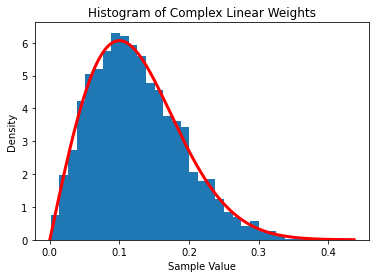

In [ ]:
plt.figure()
plt.title('Histogram of Complex Linear Weights')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.hist(linear_mag, bins=35, density=True);
plt.plot(points, ray_pdf, c='r', linewidth=3);

Finally, check that the vectors are randomly pointing everywhere.

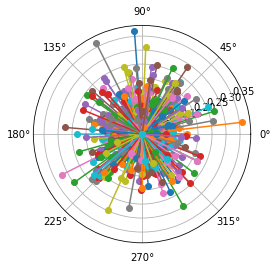

In [ ]:
# indexes for the first 500 random weights
chosen_samples = range(500)

# compute the angles
x_subset = rw[chosen_samples]
y_subset = iw[chosen_samples]
phases = np.arctan2(y_subset, x_subset)
angles = phases * 180 / np.pi

# plot these first complex weights
plt.figure()
for idx in chosen_samples:

    # index into phase and magnitude variables
    angle, mag = angles[idx], linear_mag[idx]

    # plot them starting from the origin
    plt.polar([0,angle], [0,mag], marker='o')